### Deep learning for timeseries
#### Different kinds of timeseries tasks
A **timeseries** can be any data obtained via measurements at regular intervals, like the daily price of a stock, the hourly electricity consumption of a city, or the weekly sales of a store. Timeseries are everywhere, whether we’re looking at natural phenomena (like seismic activity, the evolution of fish populations in a river, or the weather at a location) or human activity patterns (like visitors to a website, a country’s GDP, or credit card transactions). Unlike the types of data you’ve encountered so far, working with timeseries involves understanding the dynamics of a system—its periodic cycles, how it trends over time, its regular regime and its sudden spikes. <br>
By far, the most common timeseries-related task is **forecasting**: predicting what will happen next in a series. Forecast electricity consumption a few hours in advance so you can anticipate demand; forecast revenue a few months in advance so you can plan your budget; forecast the weather a few days in advance so you can plan your schedule. Forecasting is what this chapter focuses on. But there’s actually a wide range of other things you can do with timeseries:
- **Classification**—Assign one or more categorical labels to a timeseries. For instance, given the timeseries of the activity of a visitor on a website, classify whether the visitor is a bot or a human.
- **Event detection**—Identify the occurrence of a specific expected event within a continuous data stream. A particularly useful application is “hotword detection,” where a model monitors an audio stream and detects utterances like “Ok Google” or “Hey Alexa.”
- **Anomaly detection**—Detect anything unusual happening within a continuous datastream. Unusual activity on your corporate network? Might be an attacker. Unusual readings on a manufacturing line? Time for a human to go take a look. Anomaly detection is typically done via unsupervised learning, because you often don’t know what kind of anomaly you’re looking for, so you can’t train on specific anomaly examples.

When working with timeseries, you’ll encounter a wide range of domain-specific data representation techniques. For instance, you have likely already heard about the **Fourier transform**, which consists of expressing a series of values in terms of a superposition of waves of different frequencies. The Fourier transform can be highly valuable when preprocessing any data that is primarily characterized by its cycles and oscillations (like sound, the vibrations of the frame of a skyscraper, or your brain waves). In the context of deep learning, Fourier analysis (or the related Mel-frequency analysis) and other domain-specific representations can be useful as a form of feature engineering, a way to prepare data before training a model on it, to make the job of the model easier. However, we won’t cover these techniques in these pages; we will instead focus on the modeling part. <br>
In this chapter, you’ll learn about recurrent neural networks (RNNs) and how to apply them to timeseries forecasting.

#### A temperature-forecasting example
Throughout this chapter, all of our code examples will target a single problem: predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building. As you will see, it’s a fairly challenging problem! <br>
We’ll use this temperature-forecasting task to highlight what makes timeseries data fundamentally different from the kinds of datasets you’ve encountered so far. You’ll see that densely connected networks and convolutional networks aren’t well-equipped to deal with this kind of dataset, while a different kind of machine learning technique—**recurrent neural networks (RNNs)**—really shines on this type of problem.

We’ll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016. <br> Let’s start by downloading and uncompressing the data:

```python
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip
```


Now let’s look at the data.

##### Inspecting the data of the Jena weather dataset

In [4]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


This outputs a count of 420,551 lines of data (each line is a timestep: a record of a date and 14 weather-related values), as well as the headers above.

Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the “Date Time” column.

##### Parsing the data

In [5]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1] # We store column 1 in the “temperature” array.
    raw_data[i, :] = values[:] # We store all columns (including the temperature) in the “raw_data” array.

##### Plotting the temperature timeseries
The chart below shows the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature—the data spans 8 years.

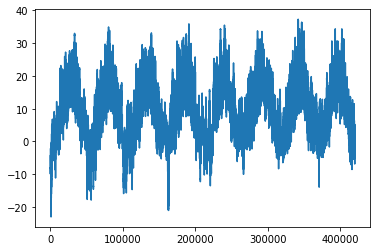

In [3]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

##### Plotting the first 10 days of the temperature timeseries
The chart below shows a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day.

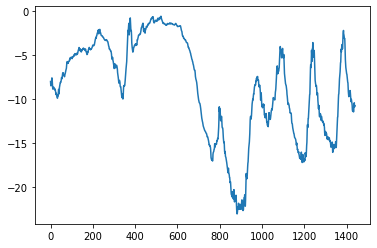

In [4]:
plt.plot(range(1440), temperature[:1440])

On this plot, you can see daily periodicity, especially for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

With our dataset, if you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out. <br>
In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. **When working with timeseries data, it’s important to use validation and test data that is more recent than the training data**, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that. Some problems happen to be considerably simpler if you reverse the time axis!

##### Computing the number of samples we’ll use for each data split

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print(f"num_train_samples: {num_train_samples}")
print(f"num_val_samples: {num_val_samples}")
print(f"num_test_samples: {num_test_samples}")

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


##### Preparing the data
The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?
- First, let’s preprocess the data to a format a neural network can ingest. 
  - This is easy: the data is already numerical, so you don’t need to do any vectorization. 
  - But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3). 
  - We’ll **normalize each timeseries independently** so that they all take small values on a similar scale. 
  - We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation **only on this fraction of the data**.

##### Normalizing the data

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Next, let’s create a Dataset object that yields batches of data from the past five days along with a target temperature 24 hours in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample. Instead, we’ll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays, and nothing more. <br>
We could easily write a Python generator to do this, but there’s a built-in dataset utility in Keras that does just that (**timeseries_dataset_from_array()**), so we can save ourselves some work by using it. You can generally use it for any kind of timeseries forecasting task.

##### Understanding timeseries_dataset_from_array()
To understand what **timeseries_dataset_from_array()** does, let’s look at a simple example. The general idea is that you provide an array of timeseries data (the data argument), and **timeseries_dataset_from_array()** gives you windows extracted from the original timeseries (we’ll call them **“sequences”**). <br>
For example, if you use **data = [0 1 2 3 4 5 6]** and **sequence_length=3**, then **timeseries_dataset_from_array()** will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6]. <br>
You can also pass a **targets** argument (an array) to **timeseries_dataset_from_array()**. The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. So if you’re doing timeseries forecasting, targets should be the same array as data, offset by some amount. <br>
For instance, with data = [0 1 2 3 4 5 6 …] and sequence_length=3, you could create a dataset to predict the next step in the series by passing targets = [3 4 5 6 …]. Let’s try it:

```python
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10) # Generate an array of sorted integers from 0 to 9.
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3], # The sequences we generate will be sampled from [0 1 2 3 4 5 6].
    targets=int_sequence[3:], # The target for the sequence that starts at data[N] will be data[N + 3].
    sequence_length=3, # The sequences will be 3 steps long.
    batch_size=2, # The sequences will be batched in batches of size 2.
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0])
```

This bit of code prints the following results:

```python
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7
```

We’ll use **timeseries_dataset_from_array()** to instantiate three datasets: one for training, one for validation, and one for testing. <br>
We’ll use the following parameter values:
- **sampling_rate = 6**—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
- **sequence_length = 120**—Observations will go back 5 days (120 hours).
- **delay = sampling_rate * (sequence_length + 24 - 1)**—The target for a sequence will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we’ll pass start_index = 0 and end_index = num_train_samples to only use the first 50% of the data. For the validation dataset, we’ll pass start_index = num_train_samples and end_index = num_train_samples + num_val_samples to use the next 25% of the data. Finally, for the test dataset, we’ll pass start_index = num_train_samples + num_val_samples to use the remaining samples.

##### Instantiating datasets for training, validation, and testing

In [8]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

##### Inspecting the output of one of our datasets

In [8]:
for samples, targets in train_dataset:
    print(f"samples shape: {samples.shape}")
    print(f"targets shape: {targets.shape}")
    break

samples shape: (256, 120, 14)
targets shape: (256,)


##### A common-sense, non-machine learning baseline
Before we start using black-box deep learning models to solve the temperature prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine learning models. Such common-sense baselines can be useful when you’re approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat. <br>
In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follows:

```python
np.mean(np.abs(preds - targets))
```

Here’s the evaluation loop.

##### Computing the common-sense baseline MAE

In [9]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the input sequence. 
        # Recall that we normalized our features, so to retrieve a temperature in degrees Celsius, we need to un-normalize it by multiplying it by the standard deviation and adding back the mean.
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average. It’s not too bad, but you probably won’t launch a weather forecasting service based on this heuristic. Now the game is to use your knowledge of deep learning to do better.

#### Let’s try a basic machine learning model
In the same way that it’s useful to establish a common-sense baseline before trying machine learning approaches, it’s useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits. <br>
- The following listing shows a fully connected model that starts by flattening the data and then runs it through two **Dense** layers. 
- **Note the lack of an activation function on the last Dense layer, which is typical for a regression problem.** 
- We use **mean squared error (MSE)** as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent. 
- We will monitor MAE by adding it as a metric in **compile()**.

##### Training and evaluating a densely connected model

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True) # We use callbacks to save the best performing model.
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Reload the best model and evaluate it on the test dataset.
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 9s 11ms/step - loss: 13.3554 - mae: 2.8220 - val_loss: 11.5500 - val_mae: 2.6908
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 9.3000 - mae: 2.3975 - val_loss: 16.0460 - val_mae: 3.1795
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 8.4063 - mae: 2.2791 - val_loss: 10.7242 - val_mae: 2.6002
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 7.8794 - mae: 2.2084 - val_loss: 11.1886 - val_mae: 2.6397
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.5057 - mae: 2.1547 - val_loss: 16.7965 - val_mae: 3.2572
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 7.2716 - mae: 2.1237 - val_loss: 10.8369 - val_mae: 2.5922
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 7.0382 - mae: 2.0898 - val_loss: 10.6679 - val_mae: 2.5682
Epoch 8/10
819/819 [==============================] - 8s 10ms

Let’s display the loss curves for validation and training.

##### Plotting results

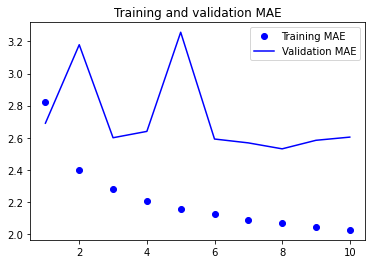

In [11]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Your common sense contains a lot of valuable information to which a machine learning model doesn’t have access. <br>
You may wonder, if a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model you’re training find it and improve on it? Well, the space of models in which you’re searching for a solution—that is, your hypothesis space—is the space of all possible two-layer networks with the configuration you defined. The common-sense heuristic is just one model among millions that can be represented in this space. It’s like looking for a needle in a haystack. Just because a good solution technically exists in your hypothesis space doesn’t mean you’ll be able to find it via gradient descent. <br>
That’s a pretty significant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, it can sometimes fail to find a simple solution to a simple problem. That’s why leveraging good feature engineering and relevant architecture priors is essential: you need to precisely tell your model what it should be looking for.

#### Let’s try a 1D convolutional model
Speaking of leveraging the right architecture priors, since our input sequences feature daily cycles, perhaps a convolutional model could work. A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image. <br>You already know about the **Conv2D** and **SeparableConv2D** layers, which see their inputs through small windows that swipe across 2D grids. There are also 1D and even 3D versions of these layers: **Conv1D**, **SeparableConv1D**, and **Conv3D**. The **Conv1D** layer relies on 1D windows that slide across input sequences, and the **Conv3D** layer relies on cubic windows that slide across input volumes. <br>
You can thus build 1D convnets, strictly analogous to 2D convnets. They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).

Let’s try one on our temperature-forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via **MaxPooling1D** layers), we’ll reduce the window size accordingly:

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu",)(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 30ms/step - loss: 21.1474 - mae: 3.6123 - val_loss: 17.3127 - val_mae: 3.3306
Epoch 2/10
819/819 [==============================] - 24s 29ms/step - loss: 14.7919 - mae: 3.0487 - val_loss: 14.8383 - val_mae: 3.0484
Epoch 3/10
819/819 [==============================] - 24s 29ms/step - loss: 13.2410 - mae: 2.8815 - val_loss: 13.3847 - val_mae: 2.8783
Epoch 4/10
819/819 [==============================] - 24s 29ms/step - loss: 12.4773 - mae: 2.7965 - val_loss: 13.7586 - val_mae: 2.9048
Epoch 5/10
819/819 [==============================] - 24s 29ms/step - loss: 11.9414 - mae: 2.7333 - val_loss: 13.3461 - val_mae: 2.8793
Epoch 6/10
819/819 [==============================] - 25s 30ms/step - loss: 11.5036 - mae: 2.6841 - val_loss: 18.2027 - val_mae: 3.3867
Epoch 7/10
819/819 [==============================] - 24s 29ms/step - loss: 11.1722 - mae: 2.6469 - val_loss: 13.5649 - val_mae: 2.8907
Epoch 8/10
819/819 [============================

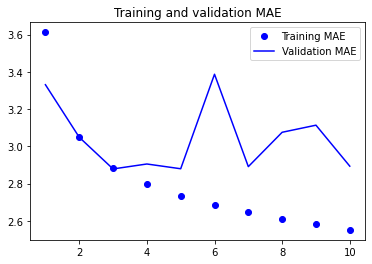

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

We get the training and validation curves shown above. <br>
As it turns out, this model performs even **worse** than the densely connected one, only achieving a validation MAE of about 2.9 degrees, far from the common-sense baseline. What went wrong here? Two things:
- First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
- Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.

#### A first recurrent baseline
Neither the fully connected approach nor the convolutional approach did well, but that doesn’t mean machine learning isn’t applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. Let’s instead look at the data as what it is: a sequence, where causality and order matter. <br>
There’s a family of neural network architectures designed specifically for this use case: **recurrent neural networks**. Among them, the **Long Short Term Memory (LSTM)** layer has long been very popular. We’ll see in a minute how these models work, but let’s start by giving the **LSTM** layer a try.

##### A simple LSTM-based model

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 61ms/step - loss: 43.5366 - mae: 4.8255 - val_loss: 12.9326 - val_mae: 2.7322
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 11.3092 - mae: 2.6045 - val_loss: 9.8349 - val_mae: 2.4394
Epoch 3/10
819/819 [==============================] - 51s 62ms/step - loss: 10.0085 - mae: 2.4650 - val_loss: 10.0591 - val_mae: 2.4528
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 9.6286 - mae: 2.4155 - val_loss: 10.0788 - val_mae: 2.4443
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 9.2305 - mae: 2.3663 - val_loss: 10.0169 - val_mae: 2.4315
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 8.8853 - mae: 2.3240 - val_loss: 9.9979 - val_mae: 2.4338
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 8.6445 - mae: 2.2951 - val_loss: 10.2956 - val_mae: 2.4575
Epoch 8/10
819/819 [==============================] - 

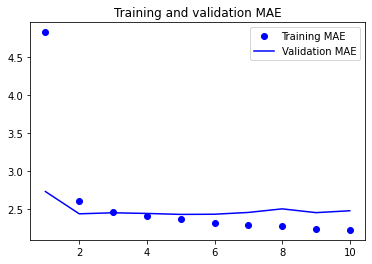

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Much better! We achieve a validation MAE as low as 2.36 degrees and a test MAE of 2.55 degrees. The LSTM-based model can finally beat the common-sense baseline (albeit just by a bit, for now), demonstrating the value of machine learning on this task. <br> But why did the LSTM model perform markedly better than the densely connected one or the convnet? And how can we further refine the model? To answer this, let’s take a closer look at recurrent neural networks.

#### Understanding recurrent neural networks
A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that **they have no memory**. Each input shown to them is **processed independently**, with no state kept between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. For instance, this is what we did in the densely connected network example: we flattened our five days of data into a single large vector and processed it in one go. Such networks are called **feedforward networks**. <br>
In contrast, as you’re reading the present sentence, you’re processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence.

Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, **built from past information and constantly updated as new information comes in**. <br>
A **recurrent neural network (RNN)** adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a state that contains information relative to what it has seen so far. In effect, an *RNN** is a type of neural network that has an internal loop (see figure 10.6).

![](./images/10.6.png)

The state of the **RNN** is reset between processing two different, independent sequences (such as two samples in a batch), so you still consider one sequence to be a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements. <br>
To make these notions of **loop** and **state** clear, let’s implement the forward pass of a toy RNN. This RNN takes as input a sequence of vectors, which we’ll encode as a rank-2 tensor of size (timesteps, input_features). It loops over timesteps, and at each timestep, it considers its current state at t and the input at t (of shape (input_features,), and combines them to obtain the output at t. We’ll then set the state for the next step to be this previous output. For the first timestep, the previous output isn’t defined; hence, there is no current state. So we’ll initialize the state as an all-zero vector called the initial state of the network. <br>
In pseudocode, this is the RNN. <br>
**Pseudocode RNN**

```python
state_t = 0 # The state at t
for input_t in input_sequence: # Iterates over sequence elements
output_t = f(input_t, state_t)
state_t = output_t # The previous output becomes the state for the next iteration.
```

You can even flesh out the function f: the transformation of the input and state into an output will be parameterized by two matrices, W and U, and a bias vector. It’s similar to the transformation operated by a densely connected layer in a feedforward network.

**More-detailed pseudocode for the RNN**

```python
state_t = 0
for input_t in input_sequence:
output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
state_t = output_t
```

To make these notions absolutely unambiguous, let’s write a naive NumPy implementation of the forward pass of the simple RNN.

##### NumPy implementation of a simple RNN

In [16]:
import numpy as np

timesteps = 100 # Number of timesteps in the input sequence
input_features = 32 # Dimensionality of the input feature space
output_features = 64 # Dimensionality of the output feature space

inputs = np.random.random((timesteps, input_features)) # Input data: random noise for the sake of the example
state_t = np.zeros((output_features,)) # Initial state: an all-zero vector
# Create random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs: # input_t is a vector of shape (input_features,)
    # Combine the input with the current state (the previous output) to obtain the current output.
    # We use tanh to add non-linearity (we could use any other activation function).
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t) # Stores this output in a list
    state_t = output_t # Updates the state of the network for the next timestep
final_output_sequence = np.stack(successive_outputs, axis=0) # The final output is a rank-2 tensor of shape(timesteps, output_features)

That’s easy enough. In summary, an RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more. Of course, there are many different RNNs fitting this definition that you could build—this example is one of the simplest RNN formulations. RNNs are characterized by their step function, such as the following function in this case (see figure 10.7).

```python
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
```

![](./images/10.7.png)

> ***NOTE*** In this example, the final output is a rank-2 tensor of shape (timesteps, output_features), where each timestep is the output of the loop at time t. Each timestep t in the output tensor contains information about timesteps 0 to t in the input sequence—about the entire past. For this reason, in many cases, you don’t need this full sequence of outputs; you just need the last output (output_t at the end of the loop), because it already contains information about the entire sequence.

#### A recurrent layer in Keras
The process we just naively implemented in NumPy corresponds to an actual Keras layer—the **SimpleRNN** layer. <br>
- There is one minor difference: **SimpleRNN** processes batches of sequences, like all other Keras layers, not a single sequence as in the NumPy example. 
- This means it takes inputs of shape **(batch_size, timesteps, input_features)**, rather than **(timesteps, input_features)**. 
- When specifying the shape argument of the initial **Input()**, note that you can set the timesteps entry to None, which enables your network to process sequences of arbitrary length.

##### An RNN layer that can process sequences of any length

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

This is especially useful if your model is meant to process sequences of variable length. However, if all of your sequences have the same length, I recommend specifying a complete input shape, since it enables model.summary() to display output length information, which is always nice, and it can unlock some performance optimizations(see the “Note on RNN runtime performance” sidebar a little later in this chapter). <br>
All recurrent layers in Keras (**SimpleRNN**, **LSTM**, and **GRU**) can be run in two different modes: 
- they can return either **full sequences of successive outputs for each timestep** (a rank-3 tensor of shape **(batch_size, timesteps, output_features)**) or 
- return only the **last output for each input sequence** (a rank-2 tensor of shape **(batch_size, output_features)**).

These two modes are controlled by the **return_sequences** constructor argument. <br>Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep.

##### An RNN layer that returns only its last output step

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs) # Note that return_sequences=False is the default.
print(outputs.shape)

(None, 16)


The following example returns the full state sequence.

##### An RNN layer that returns its full output sequence

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get **all of the intermediate layers to return a full sequence of outputs.**

##### Stacking RNN layers

In [20]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In practice, you’ll rarely work with the **SimpleRNN** layer. It’s generally too simplistic to be of real use. In particular, **SimpleRNN** has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, such long-term dependencies prove impossible to learn in practice. This is due to the **vanishing gradient** problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable. The theoretical reasons for this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s. <br>
Thankfully, **SimpleRNN** isn’t the only recurrent layer available in Keras. There are two others, **LSTM** and **GRU**, which were designed to address these issues.

Let’s consider the **LSTM** layer. The underlying **Long Short-Term Memory (LSTM)** algorithm was developed by Hochreiter and Schmidhuber in 1997;4 it was the culmination of their research on the **vanishing gradient** problem. <br>
This layer is a variant of the **SimpleRNN** layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what **LSTM** does: **it saves information for later, thus preventing older signals from gradually vanishing during processing.** This should remind you of residual connections, which you learned about in chapter 9: it’s pretty much the same idea.

To understand this process in detail, let’s start from the **SimpleRNN** cell (see figure 10.8). Because you’ll have a lot of weight matrices, index the W and U matrices in the cell, with the letter o (Wo and Uo) for output.

![](./images/10.8.png)

Let’s add to this picture an additional data flow that carries information across timesteps. Call its values at different timesteps **c_t**, where C stands for **carry**. This information will have the following impact on the cell: it will be combined with the input connection and the recurrent connection (via a dense transformation: a dot product with a weight matrix followed by a bias add and the application of an activation function), and it will affect the state being sent to the next timestep (via an activation function and a multiplication operation). Conceptually, the carry dataflow is a way to modulate the next output and the next state (see figure 10.9). Simple so far.

![](./images/10.9.png)

Now the subtlety—the way the next value of the carry dataflow is computed. It involves three distinct transformations. All three have the form of a **SimpleRNN** cell:

```python
y = activation(dot(state_t, U) + dot(input_t, W) + b)
```

But all three transformations have their own weight matrices, which we’ll index with the letters i, f, and k. Here’s what we have so far (it may seem a bit arbitrary, but bear with me).

##### Pseudocode details of the LSTM architecture (1/2)

```python
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
```
We obtain the new carry state (the next c_t) by combining i_t, f_t, and k_t.

##### Pseudocode details of the LSTM architecture (2/2)

```python
c_t+1 = i_t * k_t + c_t * f_t
```

Add this as shown in figure 10.10, and that’s it. Not so complicated—merely a tad complex.

![](./images/10.10.png)

#### Advanced use of recurrent neural networks
- **Recurrent dropout**—This is a variant of dropout, used to fight overfitting in recurrent layers.
- **Stacking recurrent layers**—This increases the representational power of the model (at the cost of higher computational loads).
- **Bidirectional recurrent layers**—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

##### Using recurrent dropout to fight overfitting
Let’s go back to the LSTM-based model we used in section 10.2.5—our first model able to beat the common-sense baseline. If you look at the training and validation curves (figure 10.5), it’s evident that the model is quickly overfitting, despite only having very few units: the training and validation losses start to diverge considerably after a few epochs. You’re already familiar with a classic technique for fighting this phenomenon: **dropout**, which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn’t a trivial question. <br>
It has long been known that **applying dropout before a recurrent layer hinders learning rather than helping with regularization**. In 2016, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use **dropout with a recurrent network**: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. What’s more, in order to regularize the representations formed by the recurrent gates of layers such as **GRU** and **LSTM**, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process. <br>
Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: **dropout**, a float specifying the dropout rate for input units of the layer, and **recurrent_dropout**, specifying the dropout rate of the recurrent units. Let’s add **recurrent dropout** to the **LSTM** layer of our first LSTM example and see how doing so impacts overfitting. <br>
Thanks to dropout, we won’t need to rely as much on network size for regularization, so we’ll use an LSTM layer with twice as many units, which should, hopefully, be more expressive (without dropout, this network would have started overfitting right away—try it). Because networks being regularized with dropout always take much longer to fully converge, we’ll train the model for five times as many epochs.

##### Training and evaluating a dropout-regularized LSTM

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x) # To regularize the Dense layer, we also add a Dropout layer after the LSTM.
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 139s 165ms/step - loss: 27.5805 - mae: 3.8773 - val_loss: 9.7764 - val_mae: 2.4227
Epoch 2/50
819/819 [==============================] - 128s 157ms/step - loss: 14.8315 - mae: 2.9919 - val_loss: 9.7257 - val_mae: 2.4173
Epoch 3/50
819/819 [==============================] - 124s 151ms/step - loss: 14.0890 - mae: 2.9086 - val_loss: 9.8778 - val_mae: 2.4449
Epoch 4/50
819/819 [==============================] - 132s 162ms/step - loss: 13.5086 - mae: 2.8455 - val_loss: 9.3280 - val_mae: 2.3659
Epoch 5/50
819/819 [==============================] - 163s 199ms/step - loss: 13.1337 - mae: 2.8080 - val_loss: 9.4471 - val_mae: 2.3880
Epoch 6/50
819/819 [==============================] - 159s 194ms/step - loss: 12.7502 - mae: 2.7637 - val_loss: 9.8792 - val_mae: 2.4337
Epoch 7/50
819/819 [==============================] - 152s 185ms/step - loss: 12.4886 - mae: 2.7331 - val_loss: 9.7251 - val_mae: 2.3966
Epoch 8/50
819/819 [=====================

![](./images/10.11.png)

Figure 10.11 shows the results. Success! We’re no longer overfitting during the first 20 epochs. We achieve a validation MAE as low as 2.27 degrees (7% improvement over the no-learning baseline) and a test MAE of 2.45 degrees (6.5% improvement over the baseline). Not too bad.

##### Stacking recurrent layers
Because you’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity and expressive power of the network. Recall the description of the universal machine learning workflow: it’s generally a good idea to increase the capacity of your model until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren’t overfitting too badly, you’re likely under capacity. <br>
Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, not too long ago the Google Translate algorithm was powered by a stack of seven large LSTM layers—that’s huge. <br> To stack recurrent layers on top of each other in Keras, **all intermediate layers should return their full sequence of outputs** (a rank-3 tensor) rather than their output at the last timestep. As you’ve already learned, this is done by specifying **return_sequences=True**.

In the following example, we’ll try a stack of two dropout-regularized recurrent layers. For a change, we’ll use **Gated Recurrent Unit (GRU)** layers instead of **LSTM**. **GRU** is very similar to **LSTM**—you can think of it as a slightly simpler, streamlined version of the LSTM architecture. It was introduced in 2014 by Cho et al. when recurrent networks were just starting to gain interest anew in the then-tiny research community.

##### Training and evaluating a dropout-regularized, stacked GRU model

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 194s 231ms/step - loss: 25.9488 - mae: 3.7562 - val_loss: 9.8788 - val_mae: 2.4270
Epoch 2/50
819/819 [==============================] - 182s 222ms/step - loss: 13.8806 - mae: 2.8845 - val_loss: 9.0271 - val_mae: 2.3335
Epoch 3/50
819/819 [==============================] - 180s 220ms/step - loss: 13.0486 - mae: 2.7997 - val_loss: 8.6224 - val_mae: 2.2736
Epoch 4/50
819/819 [==============================] - 178s 218ms/step - loss: 12.4981 - mae: 2.7431 - val_loss: 8.6645 - val_mae: 2.2840
Epoch 5/50
819/819 [==============================] - 181s 221ms/step - loss: 12.0370 - mae: 2.6899 - val_loss: 8.7455 - val_mae: 2.2993
Epoch 6/50
819/819 [==============================] - 184s 225ms/step - loss: 11.6242 - mae: 2.6458 - val_loss: 9.5626 - val_mae: 2.4238
Epoch 7/50
819/819 [==============================] - 190s 231ms/step - loss: 11.2286 - mae: 2.6024 - val_loss: 8.9347 - val_mae: 2.3395
Epoch 8/50
819/819 [=====================

Figure 10.12 shows the results. We achieve a test MAE of 2.39 degrees (an 8.8% improvement over the baseline). You can see that the added layer does improve the results a bit, though not dramatically. You may be seeing diminishing returns from increasing network capacity at this point.

![](./images/10.12.png)

#### Using bidirectional RNNs
The last technique we’ll look at in this section is the **bidirectional RNN**. A **bidirectional RNN** is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It’s frequently used in **natural language processing**—you could call it the Swiss Army knife of deep learning for natural language processing. <br>
RNNs are notably order-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely the reason they perform well on problems where order is meaningful, such as the temperature forecasting problem. A **bidirectional RNN** exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the **GRU** and **LSTM** layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. By processing a sequence both ways, a **bidirectional RNN** can catch patterns that may be overlooked by a unidirectional RNN. <br>
Remarkably, the fact that the RNN layers in this section have processed sequences in chronological order (with older timesteps first) may have been an arbitrary decision. At least, it’s a decision we’ve made no attempt to question so far. Could the RNNs have performed well enough if they processed input sequences in antichronological order, for instance (with newer timesteps first)? <br> 
Let’s try this and see what happens. All you need to do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with yield samples[:, ::-1, :], targets). Training the same LSTM-based model that you used in the first experiment in this section, you get the results shown in figure 10.13.

![](./images/10.13.png)

The reversed-order LSTM strongly underperforms even the common-sense baseline, indicating that in this case, **chronological processing is important to the success of the approach**. This makes perfect sense: the underlying LSTM layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem (that’s what makes the common-sense baseline fairly strong). Thus the chronological version of the layer is bound to outperform the reversed-order version. <br>
However, this isn’t true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence isn’t usually dependent on its position in the sentence. On text data, reversed-order processing works just as well as chronological processing—you can read text backwards just fine (try it!). Although word order does matter in understanding language, which order you use isn’t crucial. <br>
Importantly, an RNN trained on reversed sequences will learn different representations than one trained on the original sequences, much as you would have different mental models if time flowed backward in the real world—if you lived a life where you died on your first day and were born on your last day. In machine learning, representations that are different yet useful are always worth exploiting, and the more they differ, the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can help boost performance on a task. This is the intuition behind **ensembling**, a concept we’ll explore in chapter 13. <br>
A bidirectional RNN exploits this idea to improve on the performance of chronological-order RNNs. It looks at its input sequence both ways (see figure 10.14), obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![](./images/10.14.png)

To instantiate a bidirectional RNN in Keras, you use the **Bidirectional** layer, which takes as its first argument a recurrent layer instance. **Bidirectional** creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order. You can try it on our temperature-forecasting task.

##### Training and evaluating a bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

You’ll find that it doesn’t perform as well as the plain LSTM layer. It’s easy to understand why: all the predictive capacity must come from the chronological half of the network, because the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past, in this case). At the same time, the presence of the antichronological half doubles the network’s capacity and causes it to start overfitting much earlier. <br>
However, **bidirectional RNNs are a great fit for text data**, or any other kind of data **where order matters**, yet where which order you use doesn’t matter. In fact, for a while in 2016, bidirectional LSTMs were considered the state of the art on many natural language processing tasks (before the rise of the Transformer architecture, which you will learn about in the next chapter).

#### Summary
- As you first learned in chapter 5, when approaching a new problem, it’s good to first establish common-sense baselines for your metric of choice. If you don’t have a baseline to beat, you can’t tell whether you’re making real progress.
- Try simple models before expensive ones, to make sure the additional expense is justified. Sometimes a simple model will turn out to be your best option.
- When you have data where ordering matters, and in particular for timeseries data, recurrent networks are a great fit and easily outperform models that first flatten the temporal data. The two essential RNN layers available in Keras are the LSTM layer and the GRU layer.
- To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all you have to do is use the recurrent_dropout arguments of recurrent layers.
- Stacked RNNs provide more representational power than a single RNN layer. They’re also much more expensive and thus not always worth it. Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.